<a href="https://colab.research.google.com/github/akalexandrov/BioInformatics/blob/master/BurdsML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# UCSD Birds Transfer Learning Notebook: Machine Learning

This notebook is developed as a supplement to the talk titled "Transfer Learning: No Data? No Problem!" which can be found here: https://www.youtube.com/watch?v=1QeH0M8ommY.

This covers the machine learning component of the transfer learning talk where we will first extract raw pixels for ML training and later use a CNN to produce features of the images for ML training.

In [0]:
from collections import deque
from os import path
from statistics import mean
from time import time
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC, SVC
from tqdm import tqdm_notebook
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.models import alexnet, vgg16, resnet34
from torchvision.utils import make_grid, save_image
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

## Function definitions

We have two functions at work here.

The `dataset_to_numpy()` function converts the dataset from PyTorch tensor format to NumPy. YOu can additionally supply a model which will perform a forward pass producing the convolutional features of the images as a NumPy array. This streamlines the process if you were to switch models.

The `evaluate_classifier()` function simple is a wrapper for the Scikit-Learn models to train and evaluate while printing the time taken for the model to train.

In [0]:
def dataset_to_numpy(loader, iterations=1, model=None):
    X, y = [], []
    with torch.no_grad():
        for _ in range(iterations):
            for images, labels in tqdm_notebook(loader):
                if model is None:
                    x = images.view(images.size(0), -1)
                else:
                    x = model(images.to(device)).cpu()
                X.append(x.numpy())
                y.append(labels.numpy().flatten())
    
    return np.vstack(X), np.hstack(y)

In [0]:
def evaluate_classifier(classifier, X_train, y_train, X_valid, y_valid):
    start_time = time()
    classifier.fit(X_train, y_train)
    print('Time taken:', time() - start_time, 'seconds')
    print('Training score:', classifier.score(X_train, y_train))
    print('Validation score:', classifier.score(X_valid, y_valid))

## Downloading data

In [0]:
if not path.exists('./CUB-200-2011-sc.zip'):
    !wget https://syaffers-stuff.s3.amazonaws.com/datasets/CUB-200-2011-sc.zip
    !unzip CUB-200-2011-sc.zip > /dev/null

--2020-03-05 02:37:01--  https://syaffers-stuff.s3.amazonaws.com/datasets/CUB-200-2011-sc.zip
Resolving syaffers-stuff.s3.amazonaws.com (syaffers-stuff.s3.amazonaws.com)... 52.216.163.131
Connecting to syaffers-stuff.s3.amazonaws.com (syaffers-stuff.s3.amazonaws.com)|52.216.163.131|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 162198721 (155M) [application/zip]
Saving to: ‘CUB-200-2011-sc.zip’

CUB-200-2011-sc.zip 100%[===================>] 154.68M  35.9MB/s    in 4.8s    

2020-03-05 02:37:06 (32.0 MB/s) - ‘CUB-200-2011-sc.zip’ saved [162198721/162198721]



## GPU execution

In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

## Dataset and dataloader

In [0]:
train_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])

valid_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])

train_set = ImageFolder('CUB-200-2011/train', transform=train_transform)
valid_set = ImageFolder('CUB-200-2011/valid', transform=valid_transform)

train_loader = DataLoader(train_set, batch_size=128)
valid_loader = DataLoader(valid_set, batch_size=128)

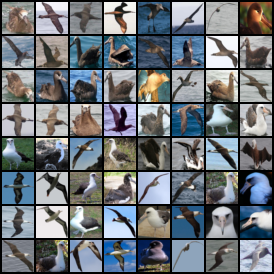

In [0]:
images, _ = next(iter(train_loader))
save_image(images[:64], 'batch.png', normalize=True)
Image.open('batch.png')

### Converting dataset to numpy arrays

In [0]:
X_train, y_train = dataset_to_numpy(train_loader)
print(X_train.shape)
print(y_train.shape)


(5994, 3072)
(5994,)


In [0]:
X_valid, y_valid = dataset_to_numpy(valid_loader)
print(X_valid.shape)
print(y_valid.shape)


(794, 3072)
(794,)


### PCA for feature reduction

# of PCs: 537


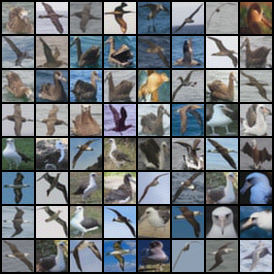

In [0]:
scale = StandardScaler()
pca = PCA(n_components=0.98)

X_train_sc = scale.fit_transform(X_train)
X_train_t = pca.fit_transform(X_train_sc)
print('# of PCs:', X_train_t.shape[1])
X_valid_t = pca.transform(scale.transform(X_valid))

# Reconstruction.
X_train_r = scale.inverse_transform(pca.inverse_transform(X_train_t))
images = torch.tensor(X_train_r.reshape(-1, 3, 32, 32)[:64])
save_image(images, 'batch_r.png', normalize=True)
Image.open('batch_r.png')

## Training with PCA features

We have extracted the pixels of $32 \times 32$ resized color images and we have used PCA to reduce the dimensionality of the data to 537 features. Now let's evaluate the performance on various traditional ML models.

### Logistic regression

In [0]:
lr = LogisticRegression(solver='liblinear')
evaluate_classifier(lr, X_train_t, y_train, X_valid_t, y_valid)

Time taken: 661.0337553024292 seconds
Training score: 1.0
Validation score: 0.05289672544080604


### Linear SVM

RBF kernels are too slow but feel free to try.

In [0]:
svm = LinearSVC()
evaluate_classifier(svm, X_train_t, y_train, X_valid_t, y_valid)

Time taken: 264.26062273979187 seconds
Training score: 1.0
Validation score: 0.037783375314861464


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


### Random forest

In [0]:
rf = RandomForestClassifier(max_depth=5, min_samples_leaf=30)
evaluate_classifier(rf, X_train_t, y_train, X_valid_t, y_valid)

Time taken: 20.068439722061157 seconds
Training score: 0.39105772439105774
Validation score: 0.03526448362720403


## Training with original features

What is the time difference when training on all 3,072 raw pixels without PCA?

### Random forest

In [0]:
rf = RandomForestClassifier(max_depth=5, min_samples_leaf=30)
evaluate_classifier(rf, X_train, y_train, X_valid, y_valid)

Time taken: 12.700305938720703 seconds
Training score: 0.26876876876876876
Validation score: 0.04030226700251889


I didn't do the rest, it took forever.

## Getting convolution features

### ImageNet preprocessing

ImageNet images are trained as $224 \times 224$ pixels color images and we need to resize as such. For training, I'm resizing to $256 \times 256$ and randomly cropping out $224 \times 224$ since that's how they did it in the paper. Then there is a weird normalization based on the PyTorch libraries.

In [0]:
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop((224, 224)),
    transforms.RandomRotation(0.2),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

valid_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_set = ImageFolder('CUB-200-2011/train', transform=train_transform)
valid_set = ImageFolder('CUB-200-2011/valid', transform=valid_transform)

train_loader = DataLoader(train_set, batch_size=256)
valid_loader = DataLoader(valid_set, batch_size=256)

### ResNet34 features

As ResNet34 has an output size of 512 fromthe convolution part of the net, we can just use this as is but since the nets `forward()` function is non-trivial (due to the skip-layers) we cannot just execute a forward pass of the convolutions, we have to do a forward pass of the entire network. Luckily, we can remove the classifier part (`fc`) and just pull out the CNN outputs using the `Identity` layer.

In [0]:
model = resnet34(pretrained=True)
model.fc = nn.Identity()
model.cuda()
model.eval()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Pass the model to the `dataset_to_numpy()` function to get the features of the net. We run for 5 iterations to multiply dataset size by 5; change this to however many you want.

In [0]:
X_train, y_train = dataset_to_numpy(train_loader, iterations=5, model=model)
X_valid, y_valid = dataset_to_numpy(valid_loader, model=model)

## Training with convolution features

### Random forest with convolution features

In [0]:
rf = RandomForestClassifier(max_depth=50)
evaluate_classifier(rf, X_train, y_train, X_valid, y_valid)

Time taken: 423.43630051612854 seconds
Training score: 1.0
Validation score: 0.5340050377833753


In [0]:
svm = LinearSVC()
evaluate_classifier(svm, X_train, y_train, X_valid, y_valid)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Time taken: 114.27745056152344 seconds
Training score: 1.0
Validation score: 0.5957178841309824


In [0]:
lr = LogisticRegression(solver='liblinear')
evaluate_classifier(lr, X_train, y_train, X_valid, y_valid)

Time taken: 1012.5290324687958 seconds
Training score: 1.0
Validation score: 0.654911838790932


## AlexNet features

Here we used average pooling instead of the adaptive average pooling to reduce the number of output features. This essentially reduces the feature size of the AlexNet CNN features from 9216 to 256.

In [0]:
model = alexnet(pretrained=True)
model.avgpool = nn.AvgPool2d((6, 6))
model.classifier = nn.Identity()
model.eval()
model.cuda()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AvgPool2d(kernel_size=(6, 6), stride=(6, 6), padding=0)
  (classifier): Identity()
)

In [0]:
X_train, y_train = dataset_to_numpy(train_loader, model=model)
X_valid, y_valid = dataset_to_numpy(valid_loader, model=model)

In [0]:
rf = RandomForestClassifier(max_depth=50)
evaluate_classifier(rf, X_train, y_train, X_valid, y_valid)

Time taken: 60.61172342300415 seconds
Training score: 1.0
Validation score: 0.345088161209068


In [0]:
svm = LinearSVC()
evaluate_classifier(svm, X_train, y_train, X_valid, y_valid)

Time taken: 22.105041980743408 seconds
Training score: 1.0
Validation score: 0.4332493702770781


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [0]:
lr = LogisticRegression(solver='liblinear')
evaluate_classifier(lr, X_train, y_train, X_valid, y_valid)

Time taken: 72.8829517364502 seconds
Training score: 0.9998331664998331
Validation score: 0.49622166246851385
